In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import tensorflow as tf
import seaborn as sns
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
heart_disease_df = pd.read_csv('/content/drive/MyDrive/heart_disease_dataset.csv')
heart_disease_df.head()

Mounted at /content/drive


,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
# Rename target column to classify risk of suffering a heart attack and sex column
heart_disease_df = heart_disease_df.rename(columns={'target': 'risk',
                        'sex': 'gender'})
heart_disease_df.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Confirm all columns are interger datatypes
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1888 non-null   int64  
 1   gender    1888 non-null   int64  
 2   cp        1888 non-null   int64  
 3   trestbps  1888 non-null   int64  
 4   chol      1888 non-null   int64  
 5   fbs       1888 non-null   int64  
 6   restecg   1888 non-null   int64  
 7   thalachh  1888 non-null   int64  
 8   exang     1888 non-null   int64  
 9   oldpeak   1888 non-null   float64
 10  slope     1888 non-null   int64  
 11  ca        1888 non-null   int64  
 12  thal      1888 non-null   int64  
 13  risk      1888 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 206.6 KB


In [4]:
# Unique values per column
heart_disease_df.nunique()

,0
age,41
gender,2
cp,5
trestbps,50
chol,152
fbs,2
restecg,3
thalachh,92
exang,2
oldpeak,40


In [5]:
# Check for missing values in each column
heart_disease_df.isnull().sum()

,0
age,0
gender,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalachh,0
exang,0
oldpeak,0


In [6]:
heart_disease_df.to_csv('cleaned_heart_disease.csv')

files.download("cleaned_heart_disease.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reading the Data Using Spark

In [7]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.3'
spark_version = 'spark-3.5.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,319 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,637 kB]
Get:13 https://r2u.stat.illinois.edu/ubunt

In [8]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [9]:
# Read the cleaned_heart_disease.csv into a PySpark DataFrame.
from pyspark import SparkFiles
url = "/content/drive/MyDrive/cleaned_heart_disease.csv"

spark.sparkContext.addFile(url)
cleaned_heart_disease_df = spark.read.csv(SparkFiles.get("cleaned_heart_disease.csv"), header=True, inferSchema=True, quote="\"", escape="\"", sep=",")

# Show DataFrame
cleaned_heart_disease_df.show()

+---+---+------+---+--------+----+---+-------+--------+-----+-------+-----+---+----+----+
|_c0|age|gender| cp|trestbps|chol|fbs|restecg|thalachh|exang|oldpeak|slope| ca|thal|risk|
+---+---+------+---+--------+----+---+-------+--------+-----+-------+-----+---+----+----+
|  0| 63|     1|  3|     145| 233|  1|      0|     150|    0|    2.3|    0|  0|   1|   1|
|  1| 37|     1|  2|     130| 250|  0|      1|     187|    0|    3.5|    0|  0|   2|   1|
|  2| 41|     0|  1|     130| 204|  0|      0|     172|    0|    1.4|    2|  0|   2|   1|
|  3| 56|     1|  1|     120| 236|  0|      1|     178|    0|    0.8|    2|  0|   2|   1|
|  4| 57|     0|  0|     120| 354|  0|      1|     163|    1|    0.6|    2|  0|   2|   1|
|  5| 57|     1|  0|     140| 192|  0|      1|     148|    0|    0.4|    1|  0|   1|   1|
|  6| 56|     0|  1|     140| 294|  0|      0|     153|    0|    1.3|    1|  0|   2|   1|
|  7| 44|     1|  1|     120| 263|  0|      1|     173|    0|    0.0|    2|  0|   3|   1|
|  8| 52| 

In [10]:
# Create a temporary view of the DataFrame.
cleaned_heart_disease_df.createOrReplaceTempView('cleaned_heart_disease')

In [11]:
# Age column displayed in descending order Using Spark

spark.sql("""
SELECT age, COUNT(age) AS count
FROM cleaned_heart_disease
GROUP BY age
ORDER BY count DESC
""").show()

+---+-----+
|age|count|
+---+-----+
| 58|  118|
| 54|  102|
| 57|   95|
| 59|   85|
| 52|   80|
| 51|   75|
| 60|   75|
| 62|   69|
| 56|   69|
| 44|   67|
| 64|   64|
| 41|   61|
| 67|   56|
| 55|   55|
| 63|   54|
| 61|   51|
| 53|   50|
| 42|   50|
| 65|   49|
| 43|   48|
+---+-----+
only showing top 20 rows



In [12]:
# Age column displayed in descending order
## 50s is the dominate age group in dataset

ages = heart_disease_df['age'].value_counts().sort_values(ascending=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

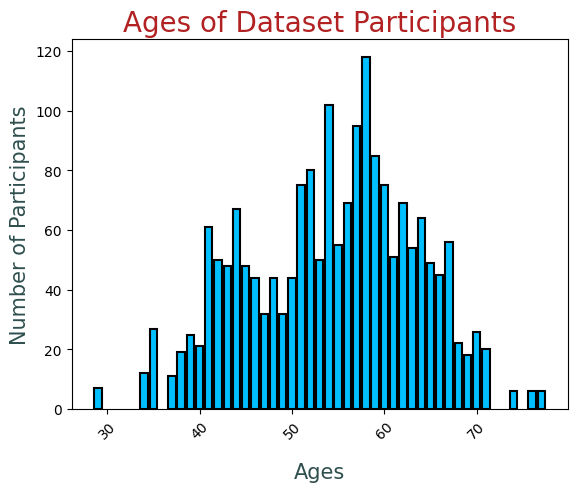

In [23]:
# Create a bar plot to visualize the distribution of ages among participants in the dataset

plt.bar(ages.index, ages, color="deepskyblue", align="center", edgecolor='k', linewidth=1.5)
plt.xticks(rotation=45, color="k")
plt.yticks(color="k")
plt.title("Ages of Dataset Participants", fontsize=20, color='firebrick')
plt.xlabel('Ages', fontsize=15, color='darkslategray', labelpad=15)
plt.ylabel('Number of Participants', fontsize=15, color='darkslategray')

plt.savefig("Ages_of_Dataset_Participants.png")
files.download("Ages_of_Dataset_Participants.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

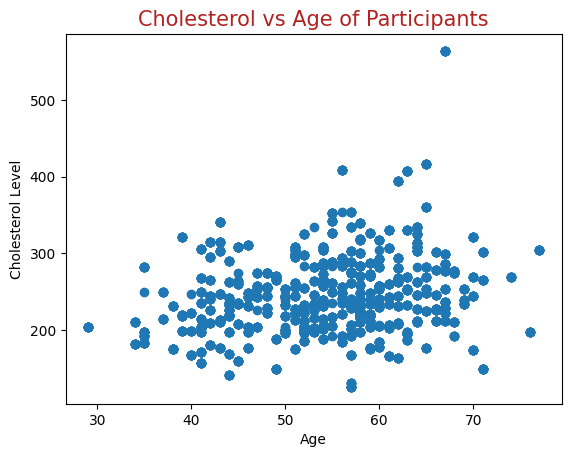

In [24]:
# Create a scatter plot to visualize the relationship between age and cholesterol level of participants
# Create scatter plot
plt.scatter(heart_disease_df["age"], heart_disease_df["chol"])

# Add labels and title
plt.xlabel("Age")
plt.ylabel("Cholesterol Level")
plt.title("Cholesterol vs Age of Participants", fontsize=15, color='firebrick')

plt.savefig("Cholesterol_vs_Age_of_Participants.png")
files.download("Cholesterol_vs_Age_of_Participants.png")

# Show plot
plt.show()

In [16]:
# Gender column value count
# 1 = Male, 0 = Female

## Possible bias
## Dataset is heavily weighed towards males

genders = heart_disease_df['gender'].value_counts()
genders

,count
gender,
1,1300
0,588


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: title={'center': 'Gender of Dataset Participants'}, xlabel='1 = Male           0 = Female', ylabel=' '>

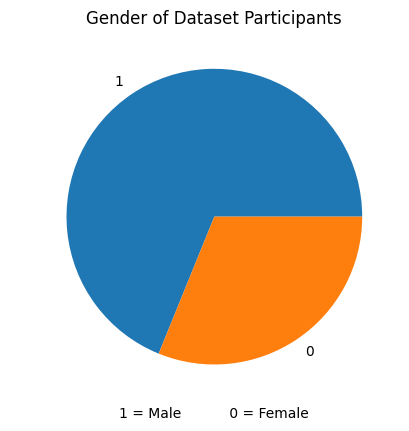

In [25]:
# Pie chart visualization of gender column's unbalanced data
# pandas chart

chart = genders.plot(kind="pie", title="Gender of Dataset Participants")
chart.set_xlabel("1 = Male           0 = Female")
chart.set_ylabel(" ")
plt.savefig("Gender_of_Dataset_Participants.png")
files.download("Gender_of_Dataset_Participants.png")
chart

In [18]:
# Fasting blood sugar (fbs) > 120 mg/dl
# 1 = true, 0 = false.

## Possible bias
## Large majority of dataset have fbs above 120 mg/dl

fbs = heart_disease_df['fbs'].value_counts()
fbs

,count
fbs,
0,1608
1,280


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: title={'center': 'Fast Blood Sugar > 120 mg/dl'}, xlabel='1 = Above 120           0 = Below 120', ylabel=' '>

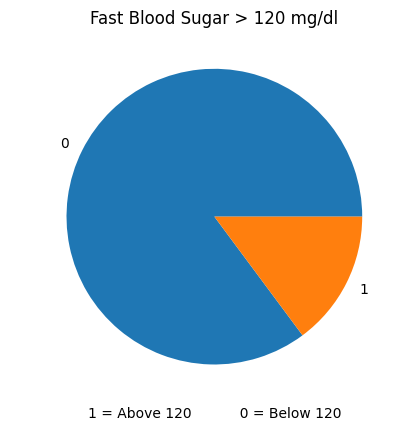

In [26]:
# Pie chart visualization of fbs column's unbalanced data
# pandas chart

chart = fbs.plot(kind="pie", title="Fast Blood Sugar > 120 mg/dl")
chart.set_xlabel("1 = Above 120           0 = Below 120")
chart.set_ylabel(" ")
plt.savefig("Fast_Blood_Sugar_greater_than_120.png")
files.download("Fast_Blood_Sugar_greater_than_120.png")
chart

In [20]:
# Risk of a heart attack
# 1 = risk, 0 = not at risk
## Near even split in data. Good to use as target column

risk = heart_disease_df['risk'].value_counts()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: title={'center': 'Likelyhood of Heart Attack'}, xlabel='1 = At Risk           0 = Not Likely', ylabel='Number of Participants'>

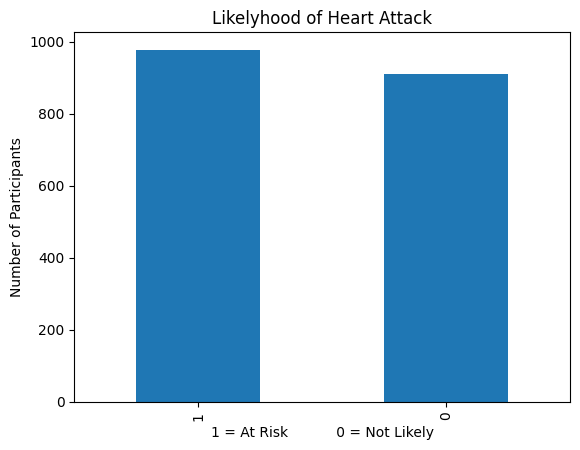

In [27]:
# Bar chart visualization of risk column's balanced data
# pandas chart

chart = risk.plot(kind="bar", title="Likelyhood of Heart Attack")
chart.set_xlabel("1 = At Risk           0 = Not Likely")
chart.set_ylabel("Number of Participants")
plt.savefig("likelyhood_of_heart_attack.png")
files.download("likelyhood_of_heart_attack.png")
chart


## Which features are the most indicative of an individual having heart disease?

<ipython-input-28-4e944fcd9834>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

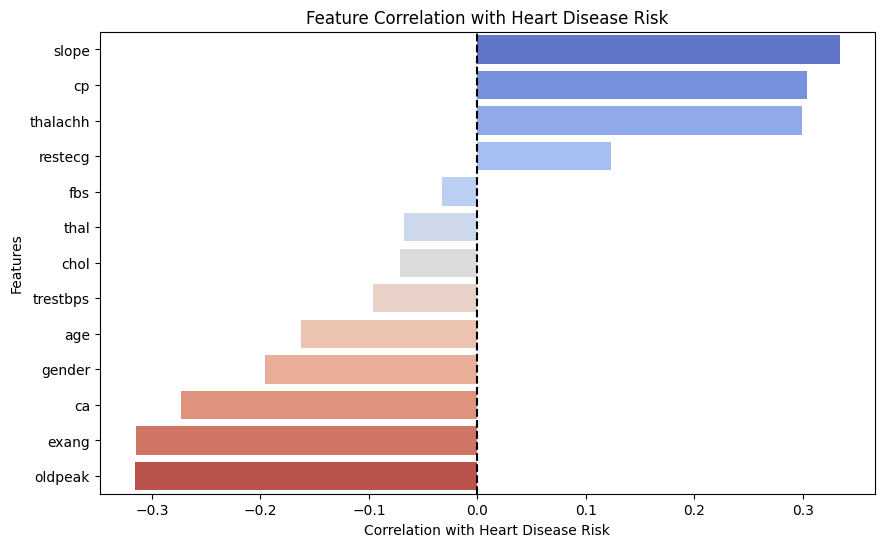

In [28]:
#Creating a barplot to see which features are the most indicative of an individual having heart disease

# Getting the correlation of the features with the target variable
corr_with_target = heart_disease_df.corr()["risk"].drop("risk")

# Sort correlations in descending order
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette="coolwarm")
plt.xlabel("Correlation with Heart Disease Risk")
plt.ylabel("Features")
plt.title("Feature Correlation with Heart Disease Risk")
plt.axvline(0, color="black", linestyle="--")
plt.savefig("feature_correlation_with_risk.png")
files.download("feature_correlation_with_risk.png")
plt.show()

This chart shows how different features correlate with the likelihood of heart disease:

Strong Positive Indicators (Higher values increase risk):

Slope: ST segment changes in ECG. Chest Pain Type (cp): Certain chest pain types indicate higher risk. Max Heart Rate (thalachh): Higher values correlate with increased risk. Strong Negative Indicators (Higher values decrease risk):

ST Depression (oldpeak): Lower values indicate higher risk. Exercise-induced Angina (exang): Presence of angina suggests greater risk. Number of Major Vessels (ca): More visible vessels mean lower risk. Weaker Indicators: Age, gender, resting blood pressure, and cholesterol show weaker correlations with heart disease risk.

Chest pain type, ST depression, and max heart rate are the strongest predictors of heart disease risk.

## What is the distribution of heart disease across different age groups?

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

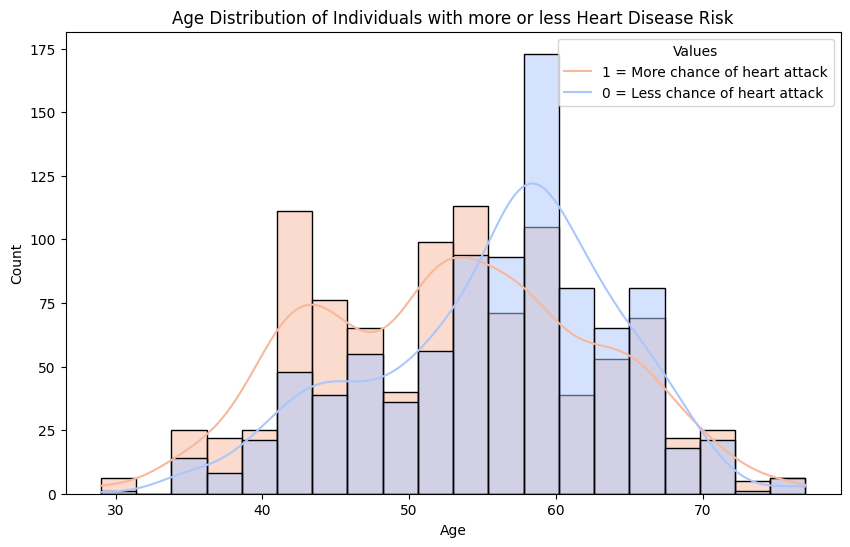

In [29]:
#Creating a histrogram plot to showcase the distribution of heart disease across different age groups

plt.figure(figsize=(10, 6))
sns.histplot(heart_disease_df, x="age", hue="risk", kde=True, bins=20, palette="coolwarm")

#labels and title
plt.title("Age Distribution of Individuals with more or less Heart Disease Risk")
plt.xlabel("Age")
plt.ylabel("Count")
# editing the legend
legend_labels = ["1 = More chance of heart attack", "0 = Less chance of heart attack"]
plt.legend(legend_labels, title="Values", loc="upper right")
plt.savefig("Age Distribution of Individuals with more or less Heart Disease Risk.png")
files.download("Age Distribution of Individuals with more or less Heart Disease Risk.png")

This histogram visualizes the distribution of individuals with and without heart disease across different age groups.

Heart disease is more prevalent among individuals aged 40 to 60, as indicated by the higher density of the orange bars in this range.Individuals in their 50s and early 60s appear to have a higher number of cases without heart disease, but heart disease cases are still present.The presence of heart disease declines after the mid-60s, possibly due to fewer older individuals in the dataset.

This graph suggests that middle-aged individuals (40–60 years old) are at a higher risk of developing heart disease compared to younger and older populations

## How does oldpeak (ST depression) affect the possibility of a heart attack?

<ipython-input-30-d9e79d25097b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="risk", y="oldpeak", data=heart_disease_df, palette="coolwarm")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

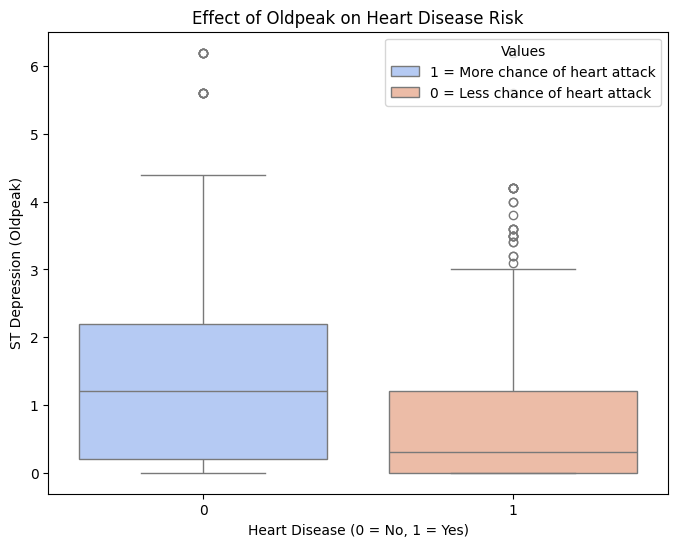

In [30]:
# Creating a boxplot to compare oldpeak values for individuals with and without heart disease.
plt.figure(figsize=(8, 6))
sns.boxplot(x="risk", y="oldpeak", data=heart_disease_df, palette="coolwarm")
plt.title("Effect of Oldpeak on Heart Disease Risk")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("ST Depression (Oldpeak)")
#Creating legend
plt.legend(legend_labels, title="Values", loc="upper right")
plt.savefig("Effect of Oldpeak on Heart Disease Ris.png")
files.download("Effect of Oldpeak on Heart Disease Ris.png")


This box plot compares ST depression levels (Oldpeak) between individuals with and without heart disease.Individuals without heart disease (0 - blue) tend to have a higher median Oldpeak value compared to those with heart disease.The spread (IQR) of Oldpeak values is larger in the group without heart disease, suggesting more variation in ST depression levels.Those with heart disease (1 - orange) generally have lower Oldpeak values, with a median closer to zero.There are more outliers in the heart disease group, indicating that some individuals with heart disease still have high ST depression values.A higher Oldpeak does not necessarily indicate a higher risk of heart disease. In fact, individuals with lower Oldpeak values seem to have a higher heart disease risk in this dataset.This suggests that ST depression alone may not be a strong predictor of heart disease and should be analyzed alongside other risk factors

## Are there threshold values for features like resting heart pressure or cholesterol levels that indicate a higher chance of having heart disease?

<ipython-input-31-ac397c93aa01>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="risk", y="trestbps", data=heart_disease_df, palette="coolwarm")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

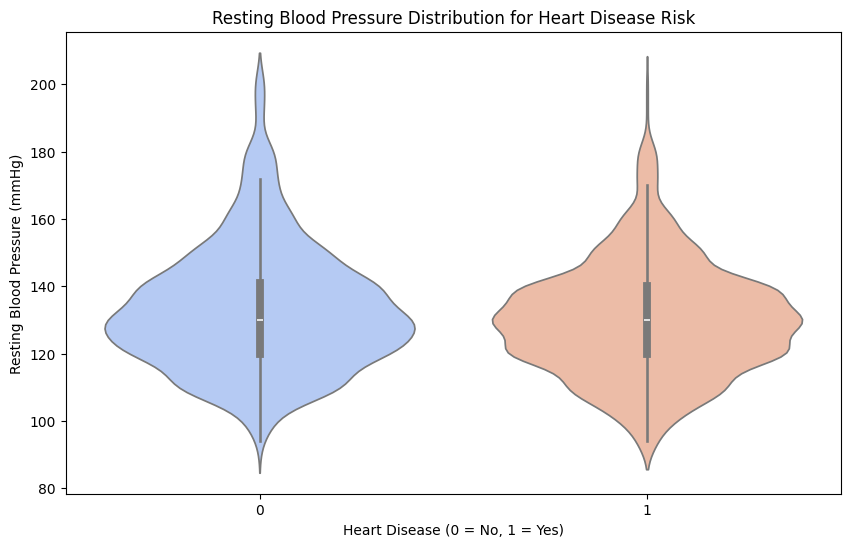

<ipython-input-31-ac397c93aa01>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="risk", y="chol", data=heart_disease_df, palette="coolwarm")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

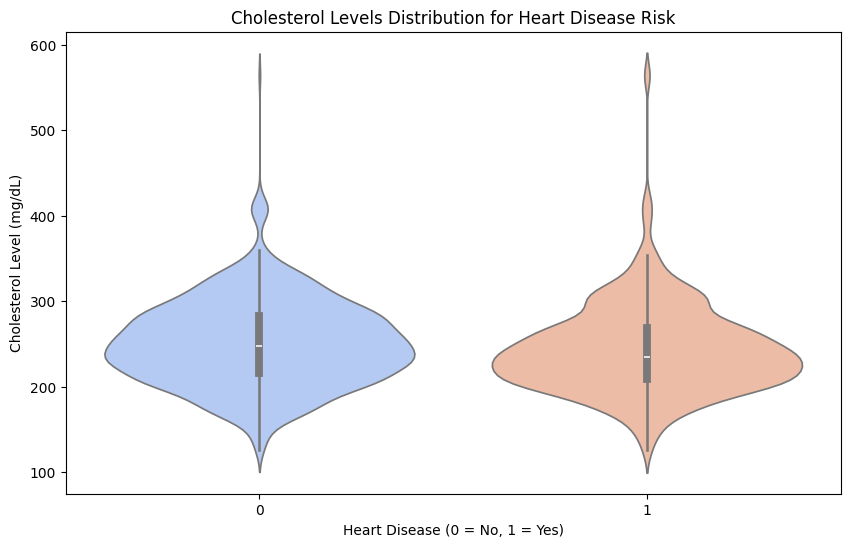

In [31]:
# Creating violin plots to show the distribution of resting blood pressure and cholesterol

# Resting Blood Pressure vs. Heart Disease
plt.figure(figsize=(10, 6))
sns.violinplot(x="risk", y="trestbps", data=heart_disease_df, palette="coolwarm")
plt.title("Resting Blood Pressure Distribution for Heart Disease Risk")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Resting Blood Pressure (mmHg)")

plt.savefig("Resting Blood Pressure Distribution for Heart Disease Risk.png")
files.download("Resting Blood Pressure Distribution for Heart Disease Risk.png")
plt.show()

# Cholesterol vs. Heart Disease
plt.figure(figsize=(10, 6))
sns.violinplot(x="risk", y="chol", data=heart_disease_df, palette="coolwarm")
plt.title("Cholesterol Levels Distribution for Heart Disease Risk")
plt.xlabel("Heart Disease (0 = No, 1 = Yes)")
plt.ylabel("Cholesterol Level (mg/dL)")

plt.savefig("Cholesterol Levels Distribution for Heart Disease Risk.png")
files.download("Cholesterol Levels Distribution for Heart Disease Risk.png")
plt.show()

## Resting Blood Pressure Distribution for Heart Disease Risk
The distribution of resting blood pressure appears similar for both individuals with low and high and heart disease risk.The spread of blood pressure values is slightly higher for individuals without heart disease.The median and interquartile range are nearly overlapping, suggesting resting blood pressure alone may not be a strong distinguishing factor for heart disease.

## Cholesterol Levels Distribution for Heart Disease Risk

Cholesterol levels exhibit a wider range for individuals without heart disease.The distribution for individuals with high risk of heart disease is slightly more concentrated around lower cholesterol levels.This suggests that cholesterol levels alone may not be a definitive predictor but still play a role in heart disease risk.

## Neural Network Model

In [32]:
# Split our preprocessed data into our features and target arrays
copy_heart_disease_df = heart_disease_df.copy()
y = copy_heart_disease_df['risk'].values
X= copy_heart_disease_df.drop(['risk'], axis='columns').values


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
# Define the model - deep neural network, specifying the number of input features and neurons for each hidden layer.
nn = tf.keras.models.Sequential()
input_layers = len(X_train[0])

hidden_layer_1 = 120
hidden_layer_2 = 60
hidden_layer_3 = 30

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_1, activation="relu", input_dim=input_layers))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_layer_3, activation="relu"))

# Output layer - sigmoid with used with binary data
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 120)                 │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 60)                  │           7,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [36]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6362 - loss: 0.6387
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8244 - loss: 0.4423
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8401 - loss: 0.3649
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.3139
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8994 - loss: 0.2571
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9340 - loss: 0.2219
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9277 - loss: 0.2017
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9470 - loss: 0.1617
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9470 - loss: 0.1524
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9664 - loss: 0.1255
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9631 - loss: 0.1040
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy:

In [37]:
# Evaluate the model using training data
model_loss, model_accuracy = nn.evaluate(X_train_scaled,y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

45/45 - 0s - 8ms/step - accuracy: 1.0000 - loss: 6.1070e-05
Loss: 6.106986984377727e-05, Accuracy: 1.0


In [38]:
# Export our model to HDF5 file
nn.save('heart_disease_model.h5')

files.download("heart_disease_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
import pickle
# Export our model to HDF5 file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Evaluate the model using test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

15/15 - 0s - 4ms/step - accuracy: 0.9682 - loss: 0.2372
Loss: 0.23724442720413208, Accuracy: 0.9682203531265259


## Loading and Preprocessing Heart Attack Encoded Data

In [41]:
# Define features set
X = heart_disease_df.copy()
X.drop("risk", axis=1, inplace=True)
X.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [42]:
# Define target vector
y = heart_disease_df["risk"].ravel()
y[:5]

<ipython-input-42-199aa6d3e971>:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = heart_disease_df["risk"].ravel()


array([1, 1, 1, 1, 1])

In [43]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=500)

In [44]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [45]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [46]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest Model

In [47]:
from sklearn.ensemble import RandomForestClassifier
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [48]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [49]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [50]:
# Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [51]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,223,6
Actual 1,8,235


Accuracy Score : 0.9703389830508474
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       229
           1       0.98      0.97      0.97       243

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472



## Feature Importance Using Random Forest

In [52]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.14198435449474156, 'thal'),
 (0.13793167467035417, 'cp'),
 (0.1008905016891258, 'thalachh'),
 (0.09382485966494421, 'oldpeak'),
 (0.08565003848466117, 'age'),
 (0.08452910104379899, 'slope'),
 (0.08295417492584131, 'chol'),
 (0.08270083466333168, 'ca'),
 (0.07401102518489844, 'trestbps'),
 (0.03902665880511431, 'restecg'),
 (0.03514416690898482, 'exang'),
 (0.030629868649516515, 'gender'),
 (0.01072274081468715, 'fbs')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

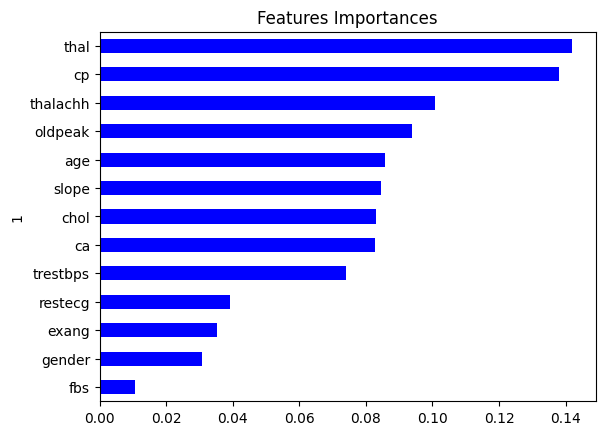

In [76]:
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='blue', title= 'Features Importances', legend=False)

## Decision Tree Model

In [54]:
# Creating the decision tree classifier instance
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [55]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [56]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [57]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)


In [58]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,220,9
Actual 1,10,233


Accuracy Score : 0.9597457627118644
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       229
           1       0.96      0.96      0.96       243

    accuracy                           0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472



## KMeans Model

In [59]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
heart_data_scaled = StandardScaler().fit_transform(heart_disease_df)

In [60]:
# Create a DataFrame with the scaled data
df_heart_scaled = pd.DataFrame(
    heart_data_scaled)

df_heart_scaled.columns = heart_disease_df.columns

# Display the scaled DataFrame
df_heart_scaled.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk
0,0.952259,0.672538,1.343864,0.766322,-0.268538,2.396426,-0.935500,0.025032,-0.70430,1.073386,-2.295053,-0.720321,-1.330518,0.965633
1,-1.911461,0.672538,0.562942,-0.088265,0.060947,-0.417288,0.630301,1.633724,-0.70430,2.106945,-2.295053,-0.720321,-0.530257,0.965633
2,-1.470888,-1.486904,-0.217980,-0.088265,-0.830601,-0.417288,-0.935500,0.981551,-0.70430,0.298216,0.933755,-0.720321,-0.530257,0.965633
3,0.181258,0.672538,-0.217980,-0.657990,-0.210394,-0.417288,0.630301,1.242420,-0.70430,-0.218564,0.933755,-0.720321,-0.530257,0.965633
4,0.291401,-1.486904,-0.998902,-0.657990,2.076620,-0.417288,0.630301,0.590248,1.41985,-0.390824,0.933755,-0.720321,-0.530257,0.965633


In [61]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
!pip install panel hvplot
import hvplot.pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 7.9 MB/s eta 0:00:00


In [62]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

In [63]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
for i in k:
    # Inside the loop:
    # 1. Create a KMeans model using the loop counter for the n_clusters
    k_model = KMeans(n_clusters=i, random_state=0)
    # 2. Fit the model to the data using `df_market_data_scaled`
    k_model.fit(df_heart_scaled)
    # 3. Append the model.inertia_ to the inertia list
    inertia.append(k_model.inertia_)

In [64]:
# Create a dictionary with the data to plot the Elbow curve
scaled_elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame with the data to plot the Elbow curve
df_scaled_elbow = pd.DataFrame(scaled_elbow_data)

In [73]:
# Plot a line chart with all the inertia values computed with
# the different values of k to visually identify the optimal value for k.
scaled_elbow_curve = df_scaled_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Scaled Elbow Curve",
    xticks=k
)

scaled_elbow_curve

:Curve   [k]   (inertia)

## Cluster Cryptocurrencies with K-means Using the Original Scaled DataFrame

In [66]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=7, random_state=0)

In [67]:
# Fit the K-Means model using the scaled DataFrame
model.fit(df_heart_scaled)

KMeans(n_clusters=7, random_state=0)

In [68]:
# Predict the clusters to group the cryptocurrencies using the scaled DataFrame
heart_clusters = model.predict(df_heart_scaled)

# Print the resulting array of cluster values.
print(heart_clusters)

[3 0 0 ... 2 2 1]


In [69]:
# Create a copy of the scaled DataFrame
df_heart_scaled_predictions = df_heart_scaled.copy()

In [70]:
# Add a new column to the copy of the scaled DataFrame with the predicted clusters
df_heart_scaled_predictions["HeartCluster"] = heart_clusters

# Display the copy of the scaled DataFrame
df_heart_scaled_predictions.head()

,age,gender,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,risk,HeartCluster
0,0.952259,0.672538,1.343864,0.766322,-0.268538,2.396426,-0.935500,0.025032,-0.70430,1.073386,-2.295053,-0.720321,-1.330518,0.965633,3
1,-1.911461,0.672538,0.562942,-0.088265,0.060947,-0.417288,0.630301,1.633724,-0.70430,2.106945,-2.295053,-0.720321,-0.530257,0.965633,0
2,-1.470888,-1.486904,-0.217980,-0.088265,-0.830601,-0.417288,-0.935500,0.981551,-0.70430,0.298216,0.933755,-0.720321,-0.530257,0.965633,0
3,0.181258,0.672538,-0.217980,-0.657990,-0.210394,-0.417288,0.630301,1.242420,-0.70430,-0.218564,0.933755,-0.720321,-0.530257,0.965633,0
4,0.291401,-1.486904,-0.998902,-0.657990,2.076620,-0.417288,0.630301,0.590248,1.41985,-0.390824,0.933755,-0.720321,-0.530257,0.965633,5


In [72]:
# Create a scatter plot using hvPlot by setting
scaled_clusters = df_heart_scaled_predictions.hvplot.scatter(
    x="thal",
    y="cp",
    by="HeartCluster",
    title = "Scaled Cluster"
)

scaled_clusters

:NdOverlay   [HeartCluster]
   :Scatter   [thal]   (cp)